In [ ]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 📁 데이터 불러오기
df = pd.read_parquet('prepro_data.parquet')

In [ ]:
# 추가 학습 코드
# history_additional = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=50,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
#     initial_epoch=27,         # 14번째까지 학습했다면 여기서 이어서 시작
#     callbacks=[early_stop, reduce_lr]
# )

Epoch 28/50
46718/46718 [==============================] - 698s 15ms/step - loss: 0.0247 - val_loss: 0.0404 - lr: 3.1250e-05
Epoch 29/50
46718/46718 [==============================] - 749s 16ms/step - loss: 0.0246 - val_loss: 0.0399 - lr: 3.1250e-05
Epoch 30/50
46718/46718 [==============================] - 726s 16ms/step - loss: 0.0246 - val_loss: 0.0417 - lr: 3.1250e-05
Epoch 31/50
46718/46718 [==============================] - 703s 15ms/step - loss: 0.0246 - val_loss: 0.0398 - lr: 3.1250e-05
Epoch 32/50
46718/46718 [==============================] - 705s 15ms/step - loss: 0.0246 - val_loss: 0.0398 - lr: 3.1250e-05
Epoch 33/50
46718/46718 [==============================] - 649s 14ms/step - loss: 0.0246 - val_loss: 0.0396 - lr: 3.1250e-05
Epoch 34/50
46718/46718 [==============================] - 649s 14ms/step - loss: 0.0246 - val_loss: 0.0402 - lr: 3.1250e-05
Epoch 35/50
46718/46718 [==============================] - 664s 14ms/step - loss: 0.0246 - val_loss: 0.0403 - lr: 3.1250e-05


# 1호선

## 1호선 데이터 불러오기

In [ ]:
df1 = df[df['호선'] == 1].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

## 배치사이즈 32

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
batch_size = 32
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21


# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line1_model_batch32 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line1_model_batch32.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line1_batch32 = Line1_model_batch32.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop
                                                                              ,reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
54544/68303 [======================>.......] - ETA: 4:07 - loss: 0.1269


KeyboardInterrupt



In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line1_batch32.history['loss'], label='Train Loss')
plt.plot(history_Line1_batch32.history['val_loss'], label='Validation Loss')
plt.title('Line1 / Batch 32 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 64

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
batch_size = 64
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line1_model_batch64 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line1_model_batch64.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line1_batch64 = Line1_model_batch64.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
31575/34152 [==========================>...] - ETA: 1:02 - loss: 0.1445

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line1_batch64.history['loss'], label='Train Loss')
plt.plot(history_Line1_batch64.history['val_loss'], label='Validation Loss')
plt.title('Line5 / Batch 64 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 128

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
batch_size = 128
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line1_model_batch128 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line1_model_batch128.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_line5_batch128 = Line1_model_batch128.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

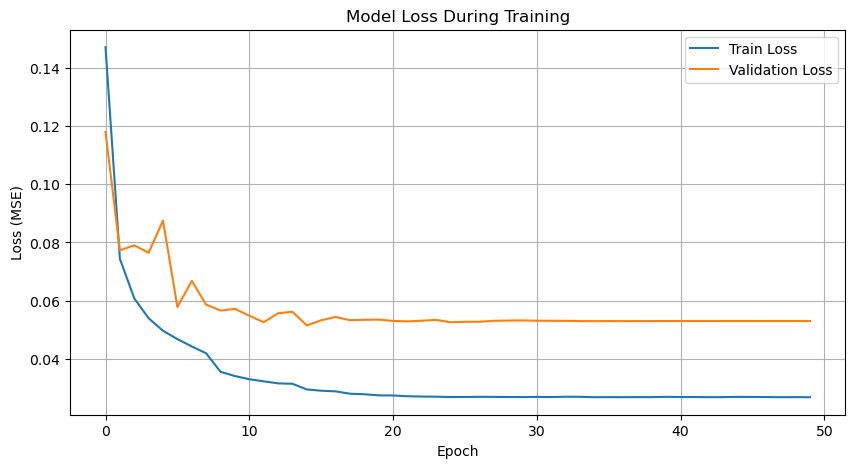

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line1_batch128.history['loss'], label='Train Loss')
plt.plot(history_Line1_batch128.history['val_loss'], label='Validation Loss')
plt.title('Line1 / Batch 128 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 256

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 1
batch_size = 256
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line1_model_batch256 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line1_model_batch256.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line1_batch256 = Line1_model_batch256.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line1_batch256.history['loss'], label='Train Loss')
plt.plot(history_Line1_batch256.history['val_loss'], label='Validation Loss')
plt.title('Line1 / Batch 256 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 1호선 모델 성능 테스트

In [ ]:
plt.rcParams['font.family']='Malgun Gothic'

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_32 = load_model('./models/Line1_batch32.h5')
loaded_model_64 = load_model('./models/Line1_batch64.h5')
loaded_model_128 = load_model('./models/Line1_batch128.h5')
loaded_model_256 = load_model('./models/Line1_batch256.h5')

# 검증셋에 대해 예측 수행
pred_scaled_32 = loaded_model_32.predict(val_gen)
pred_scaled_64 = loaded_model_64.predict(val_gen)
pred_scaled_128 = loaded_model_128.predict(val_gen)
pred_scaled_256 = loaded_model_256.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_32 = ss.inverse_transform(pred_scaled_32)
pred_64 = ss.inverse_transform(pred_scaled_64)
pred_128 = ss.inverse_transform(pred_scaled_128)
pred_256 = ss.inverse_transform(pred_scaled_256)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
rmse_32 = mean_squared_error(true, pred_32, squared=False)  # RMSE
r2_32 = r2_score(true, pred_32)                             # R² Score
rmse_64 = mean_squared_error(true, pred_64, squared=False)  # RMSE
r2_64 = r2_score(true, pred_64)                             # R² Score
rmse_128 = mean_squared_error(true, pred_128, squared=False)  # RMSE
r2_128 = r2_score(true, pred_128)                             # R² Score
rmse_256 = mean_squared_error(true, pred_256, squared=False)  # RMSE
r2_256 = r2_score(true, pred_256)                             # R² Score

# 결과 출력
print('✅Line1 batch size = 32')
print(f" 검증 RMSE: {rmse_32:.4f}")
print(f" R² Score: {r2_32:.4f}")
print()
print('✅Line1 batch size = 64')
print(f" 검증 RMSE: {rmse_64:.4f}")
print(f" R² Score: {r2_64:.4f}")
print()
print('✅Line1 batch size = 128')
print(f" 검증 RMSE: {rmse_128:.4f}")
print(f" R² Score: {r2_128:.4f}")
print()
print('✅Line1 batch size = 256')
print(f" 검증 RMSE: {rmse_256:.4f}")
print(f" R² Score: {r2_256:.4f}")

✅batch size = 32
 검증 RMSE: 4.0428
 R² Score: 0.9709

✅batch size = 64
 검증 RMSE: 4.6141
 R² Score: 0.9620

✅batch size = 128
 검증 RMSE: 4.8596
 R² Score: 0.9579

✅batch size = 256
 검증 RMSE: 4.6932
 R² Score: 0.9607


# 2호선

## 2호선 데이터 불러오기

In [ ]:
df1 = df[df['호선'] == 2].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

## 배치사이즈 32

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
batch_size = 32
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21


# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line2_model_batch32 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line2_model_batch32.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line2_batch32 = Line2_model_batch32.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop
                                                                              ,reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
54544/68303 [======================>.......] - ETA: 4:07 - loss: 0.1269


KeyboardInterrupt



In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line2_batch32.history['loss'], label='Train Loss')
plt.plot(history_Line2_batch32.history['val_loss'], label='Validation Loss')
plt.title('Line2 / Batch 32 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 64

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
batch_size = 64
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line2_model_batch64 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line2_model_batch64.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line2_batch64 = Line2_model_batch64.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
31575/34152 [==========================>...] - ETA: 1:02 - loss: 0.1445

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line2_batch64.history['loss'], label='Train Loss')
plt.plot(history_Line2_batch64.history['val_loss'], label='Validation Loss')
plt.title('Line2 / Batch 64 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 128

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
batch_size = 128
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line2_model_batch128 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line2_model_batch128.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line2_batch128 = Line2_model_batch128.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

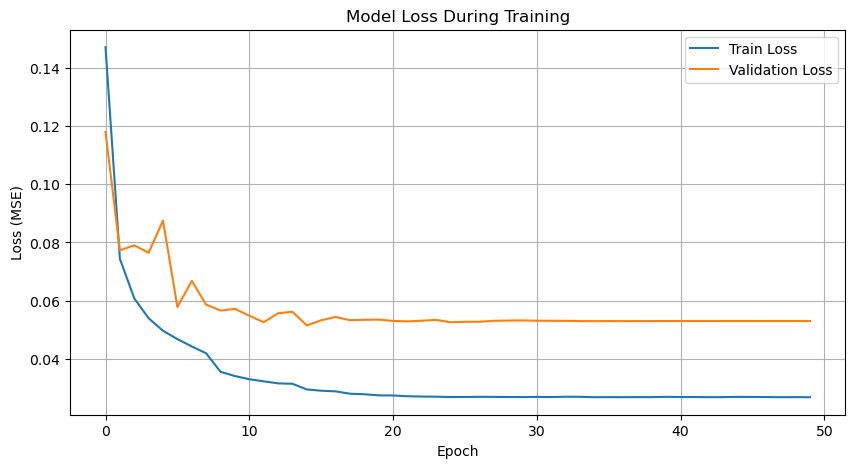

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line2_batch128.history['loss'], label='Train Loss')
plt.plot(history_Line2_batch128.history['val_loss'], label='Validation Loss')
plt.title('Line2 / Batch 128 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 256

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 2
batch_size = 256
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line2_model_batch256 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line2_model_batch256.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line2_batch256 = Line2_model_batch256.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line2_batch256.history['loss'], label='Train Loss')
plt.plot(history_Line2_batch256.history['val_loss'], label='Validation Loss')
plt.title('Line2 / Batch 256 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 2호선 모델 성능 테스트

In [ ]:
plt.rcParams['font.family']='Malgun Gothic'

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_32 = load_model('./models/Line2_batch32.h5')
loaded_model_64 = load_model('./models/Line2_batch64.h5')
loaded_model_128 = load_model('./models/Line2_batch128.h5')
loaded_model_256 = load_model('./models/Line2_batch256.h5')

# 검증셋에 대해 예측 수행
pred_scaled_32 = loaded_model_32.predict(val_gen)
pred_scaled_64 = loaded_model_64.predict(val_gen)
pred_scaled_128 = loaded_model_128.predict(val_gen)
pred_scaled_256 = loaded_model_256.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_32 = ss.inverse_transform(pred_scaled_32)
pred_64 = ss.inverse_transform(pred_scaled_64)
pred_128 = ss.inverse_transform(pred_scaled_128)
pred_256 = ss.inverse_transform(pred_scaled_256)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
rmse_32 = mean_squared_error(true, pred_32, squared=False)  # RMSE
r2_32 = r2_score(true, pred_32)                             # R² Score
rmse_64 = mean_squared_error(true, pred_64, squared=False)  # RMSE
r2_64 = r2_score(true, pred_64)                             # R² Score
rmse_128 = mean_squared_error(true, pred_128, squared=False)  # RMSE
r2_128 = r2_score(true, pred_128)                             # R² Score
rmse_256 = mean_squared_error(true, pred_256, squared=False)  # RMSE
r2_256 = r2_score(true, pred_256)                             # R² Score

# 결과 출력
print('✅Line2 batch size = 32')
print(f" 검증 RMSE: {rmse_32:.4f}")
print(f" R² Score: {r2_32:.4f}")
print()
print('✅Line2 batch size = 64')
print(f" 검증 RMSE: {rmse_64:.4f}")
print(f" R² Score: {r2_64:.4f}")
print()
print('✅Line2 batch size = 128')
print(f" 검증 RMSE: {rmse_128:.4f}")
print(f" R² Score: {r2_128:.4f}")
print()
print('✅Line2 batch size = 256')
print(f" 검증 RMSE: {rmse_256:.4f}")
print(f" R² Score: {r2_256:.4f}")

✅batch size = 32
 검증 RMSE: 4.0428
 R² Score: 0.9709

✅batch size = 64
 검증 RMSE: 4.6141
 R² Score: 0.9620

✅batch size = 128
 검증 RMSE: 4.8596
 R² Score: 0.9579

✅batch size = 256
 검증 RMSE: 4.6932
 R² Score: 0.9607


# 3호선

## 3호선 데이터 불러오기

In [ ]:
df1 = df[df['호선'] == 3].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

## 배치사이즈 32

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
batch_size = 32
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21


# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line3_model_batch32 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line3_model_batch32.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line3_batch32 = Line3_model_batch32.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop
                                                                              ,reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
54544/68303 [======================>.......] - ETA: 4:07 - loss: 0.1269


KeyboardInterrupt



In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line3_batch32.history['loss'], label='Train Loss')
plt.plot(history_Line3_batch32.history['val_loss'], label='Validation Loss')
plt.title('Line3 / Batch 32 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 64

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
batch_size = 64
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line3_model_batch64 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line3_model_batch64.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line3_batch64 = Line3_model_batch64.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
31575/34152 [==========================>...] - ETA: 1:02 - loss: 0.1445

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line3_batch64.history['loss'], label='Train Loss')
plt.plot(history_Line3_batch64.history['val_loss'], label='Validation Loss')
plt.title('Line3 / Batch 64 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 128

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
batch_size = 128
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line3_model_batch128 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line3_model_batch128.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line3_batch128 = Line3_model_batch128.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

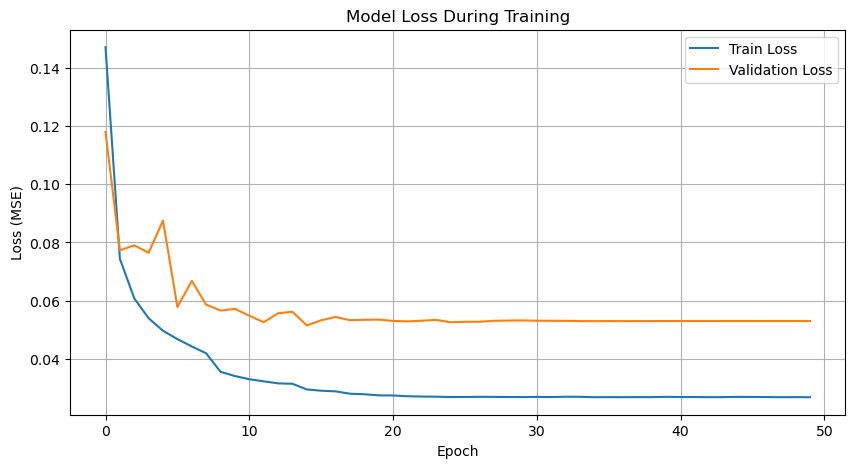

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line3_batch128.history['loss'], label='Train Loss')
plt.plot(history_Line3_batch128.history['val_loss'], label='Validation Loss')
plt.title('Line3 / Batch 128 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 256

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 3
batch_size = 256
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line3_model_batch256 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line3_model_batch256.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line3_batch256 = Line3_model_batch256.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line3_batch256.history['loss'], label='Train Loss')
plt.plot(history_Line3_batch256.history['val_loss'], label='Validation Loss')
plt.title('Line3 / Batch 256 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 3호선 모델 성능 테스트

In [ ]:
plt.rcParams['font.family']='Malgun Gothic'

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_32 = load_model('./models/Line3_batch32.h5')
loaded_model_64 = load_model('./models/Line3_batch64.h5')
loaded_model_128 = load_model('./models/Line3_batch128.h5')
loaded_model_256 = load_model('./models/Line3_batch256.h5')

# 검증셋에 대해 예측 수행
pred_scaled_32 = loaded_model_32.predict(val_gen)
pred_scaled_64 = loaded_model_64.predict(val_gen)
pred_scaled_128 = loaded_model_128.predict(val_gen)
pred_scaled_256 = loaded_model_256.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_32 = ss.inverse_transform(pred_scaled_32)
pred_64 = ss.inverse_transform(pred_scaled_64)
pred_128 = ss.inverse_transform(pred_scaled_128)
pred_256 = ss.inverse_transform(pred_scaled_256)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
rmse_32 = mean_squared_error(true, pred_32, squared=False)  # RMSE
r2_32 = r2_score(true, pred_32)                             # R² Score
rmse_64 = mean_squared_error(true, pred_64, squared=False)  # RMSE
r2_64 = r2_score(true, pred_64)                             # R² Score
rmse_128 = mean_squared_error(true, pred_128, squared=False)  # RMSE
r2_128 = r2_score(true, pred_128)                             # R² Score
rmse_256 = mean_squared_error(true, pred_256, squared=False)  # RMSE
r2_256 = r2_score(true, pred_256)                             # R² Score

# 결과 출력
print('✅Line3 batch size = 32')
print(f" 검증 RMSE: {rmse_32:.4f}")
print(f" R² Score: {r2_32:.4f}")
print()
print('✅Line3 batch size = 64')
print(f" 검증 RMSE: {rmse_64:.4f}")
print(f" R² Score: {r2_64:.4f}")
print()
print('✅Line3 batch size = 128')
print(f" 검증 RMSE: {rmse_128:.4f}")
print(f" R² Score: {r2_128:.4f}")
print()
print('✅Line3 batch size = 256')
print(f" 검증 RMSE: {rmse_256:.4f}")
print(f" R² Score: {r2_256:.4f}")

✅batch size = 32
 검증 RMSE: 4.0428
 R² Score: 0.9709

✅batch size = 64
 검증 RMSE: 4.6141
 R² Score: 0.9620

✅batch size = 128
 검증 RMSE: 4.8596
 R² Score: 0.9579

✅batch size = 256
 검증 RMSE: 4.6932
 R² Score: 0.9607


# 4호선

## 4호선 데이터 불러오기

In [ ]:
df1 = df[df['호선'] == 4].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

## 배치사이즈 32

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 32
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21


# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch32 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch32.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch32 = Line4_model_batch32.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop
                                                                              ,reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
54544/68303 [======================>.......] - ETA: 4:07 - loss: 0.1269


KeyboardInterrupt



In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch32.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch32.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 32 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 64

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 64
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch64 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch64.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch64 = Line4_model_batch64.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
31575/34152 [==========================>...] - ETA: 1:02 - loss: 0.1445

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch64.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch64.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 64 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 128

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 128
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch128 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch128.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch128 = Line4_model_batch128.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

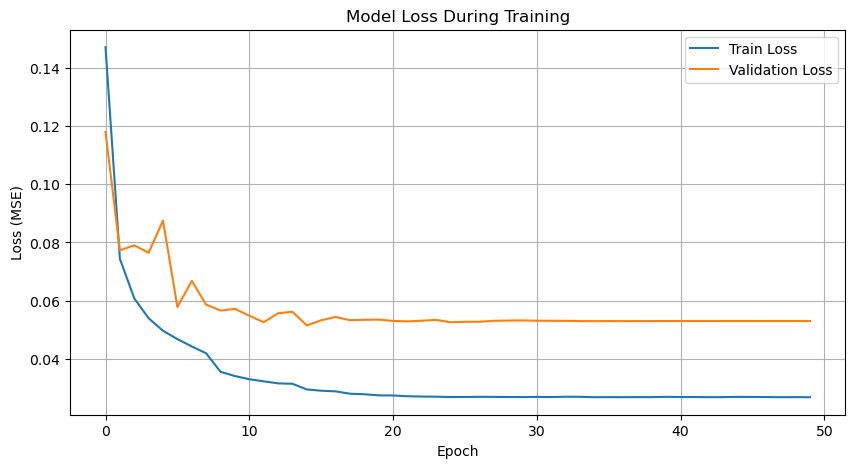

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch128.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch128.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 128 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 배치사이즈 256

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

line = 4
batch_size = 256
save_path = './models/Line{}_batch{}.h5'.format(line, batch_size)

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath=save_path,         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
Line4_model_batch256 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
Line4_model_batch256.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history_Line4_batch256 = Line4_model_batch256.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              early_stop,
                                                                              reduce_lr
                                                                            ,checkpoint])

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_Line4_batch256.history['loss'], label='Train Loss')
plt.plot(history_Line4_batch256.history['val_loss'], label='Validation Loss')
plt.title('Line4 / Batch 256 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 4호선 모델 성능 테스트

In [ ]:
plt.rcParams['font.family']='Malgun Gothic'

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_32 = load_model('./models/Line4_batch32.h5')
loaded_model_64 = load_model('./models/Line4_batch64.h5')
loaded_model_128 = load_model('./models/Line4_batch128.h5')
loaded_model_256 = load_model('./models/Line4_batch256.h5')

# 검증셋에 대해 예측 수행
pred_scaled_32 = loaded_model_32.predict(val_gen)
pred_scaled_64 = loaded_model_64.predict(val_gen)
pred_scaled_128 = loaded_model_128.predict(val_gen)
pred_scaled_256 = loaded_model_256.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_32 = ss.inverse_transform(pred_scaled_32)
pred_64 = ss.inverse_transform(pred_scaled_64)
pred_128 = ss.inverse_transform(pred_scaled_128)
pred_256 = ss.inverse_transform(pred_scaled_256)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [ ]:
# 평가 지표 계산
rmse_32 = mean_squared_error(true, pred_32, squared=False)  # RMSE
r2_32 = r2_score(true, pred_32)                             # R² Score
rmse_64 = mean_squared_error(true, pred_64, squared=False)  # RMSE
r2_64 = r2_score(true, pred_64)                             # R² Score
rmse_128 = mean_squared_error(true, pred_128, squared=False)  # RMSE
r2_128 = r2_score(true, pred_128)                             # R² Score
rmse_256 = mean_squared_error(true, pred_256, squared=False)  # RMSE
r2_256 = r2_score(true, pred_256)                             # R² Score

# 결과 출력
print('✅Line4 batch size = 32')
print(f" 검증 RMSE: {rmse_32:.4f}")
print(f" R² Score: {r2_32:.4f}")
print()
print('✅Line4 batch size = 64')
print(f" 검증 RMSE: {rmse_64:.4f}")
print(f" R² Score: {r2_64:.4f}")
print()
print('✅Line4 batch size = 128')
print(f" 검증 RMSE: {rmse_128:.4f}")
print(f" R² Score: {r2_128:.4f}")
print()
print('✅Line4 batch size = 256')
print(f" 검증 RMSE: {rmse_256:.4f}")
print(f" R² Score: {r2_256:.4f}")

✅batch size = 32
 검증 RMSE: 4.0428
 R² Score: 0.9709

✅batch size = 64
 검증 RMSE: 4.6141
 R² Score: 0.9620

✅batch size = 128
 검증 RMSE: 4.8596
 R² Score: 0.9579

✅batch size = 256
 검증 RMSE: 4.6932
 R² Score: 0.9607
